<a href="https://colab.research.google.com/github/HarmanDotpy/RNNs-LSTMs/blob/master/LSTM_Multivariate_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

class LSTMmodel(nn.Module):
  def __init__(self):
    super(LSTMmodel, self).__init__() 
    
    self.input_size = 3 #is the number of expected input features x
    self.hidden_size = 50 # is the hidden layer size, ie its the size of a, the hidden state
    self.num_layers = 2 # num layers is the number of stacked LSTM layersb we want
    self.output_size = 3
    self.seq_length = 3 
    self.batch_size = 6
    
    self.lstm = nn.LSTM(input_size = self.input_size, hidden_size = self.hidden_size, num_layers = self.num_layers, batch_first = True)
    self.linear = nn.Sequential(
                      nn.Linear(self.hidden_size, self.output_size),
                      nn.ReLU()
                  )
  def init_hidden(self):
    return (torch.randn(self.num_layers, self.batch_size, self.hidden_size) * 0.01,
            torch.randn(self.num_layers, self.batch_size, self.hidden_size) * 0.01)

  def forward(self, x):

    lstm_out, self.hidden = self.lstm(x)
    # lstm_out has dimensions (batch, seq_length,num_directions * hidden_size)
    y_pred = self.linear(lstm_out[:, -1, :].reshape(-1, self.hidden_size))
    # y_pred has size batch_size * ouput_size
    return y_pred





In [7]:
# This block of code is taken from https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
# Generating data in this block of code
# multivariate output data prep
from numpy import array
from numpy import hstack
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)
print(X.shape, y.shape)
print(dataset.shape)
# summarize the data
for i in range(len(X)):
	print(X[i], y[i])


X_train = torch.Tensor(X)
y_train = torch.Tensor(y)
print(X_train.shape, y_train.shape)
# X_train = X_train.reshape(X_train.shape[1], X_train.shape[0], X_train.shape[2])
# print(X_train)
# print(y_train)
# print(X_train.shape, y_train.shape)

(6, 3, 3) (6, 3)
(9, 3)
[[10 15 25]
 [20 25 45]
 [30 35 65]] [40 45 85]
[[20 25 45]
 [30 35 65]
 [40 45 85]] [ 50  55 105]
[[ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]] [ 60  65 125]
[[ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]] [ 70  75 145]
[[ 50  55 105]
 [ 60  65 125]
 [ 70  75 145]] [ 80  85 165]
[[ 60  65 125]
 [ 70  75 145]
 [ 80  85 165]] [ 90  95 185]
torch.Size([6, 3, 3]) torch.Size([6, 3])


In [8]:
# initialize model
model = LSTMmodel()


# keeping batch size as total number of training examples
learning_rate = 0.01
batch_size = X.shape[0]
lossfunction = nn.MSELoss(reduction = 'mean')
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
num_epochs = 2000

loss_list = []

# Training model
for i in range(num_epochs):

  # initialize hidden state
  model.hidden = model.init_hidden()

  # predict output
  y_pred = model(X_train)

  # calculate loss
  loss = lossfunction(y_pred, y_train)
  
  # backpropogate
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if(i %100 ==0):
    print('Epoch = {}, Loss = {}'.format(i, loss))
  loss_list.append(loss)


# NOTE : If model doesnot converge then try and re run it
# my speculation is that some of the outputs always become zero due to 
# wrong initialization, hence re-running most of the time works

Epoch = 0, Loss = 9691.0869140625
Epoch = 100, Loss = 3471.34619140625
Epoch = 200, Loss = 1446.9765625
Epoch = 300, Loss = 810.109130859375
Epoch = 400, Loss = 629.9395751953125
Epoch = 500, Loss = 278.9823303222656
Epoch = 600, Loss = 123.60848236083984
Epoch = 700, Loss = 68.57200622558594
Epoch = 800, Loss = 31.07886505126953
Epoch = 900, Loss = 21.40212059020996
Epoch = 1000, Loss = 18.2934513092041
Epoch = 1100, Loss = 17.28177833557129
Epoch = 1200, Loss = 13.15811538696289
Epoch = 1300, Loss = 4.206226348876953
Epoch = 1400, Loss = 1.7791372537612915
Epoch = 1500, Loss = 0.7641615867614746
Epoch = 1600, Loss = 0.557267427444458
Epoch = 1700, Loss = 0.15440508723258972
Epoch = 1800, Loss = 0.08307984471321106
Epoch = 1900, Loss = 0.04306900501251221


In [9]:
# Testing if it generates the next output in the sequence
model.eval()
input = torch.Tensor([[[60, 65, 125], [70, 75, 145], [80, 85, 165]]])
print(input.shape)
out = model(input)
print(out)

torch.Size([1, 3, 3])
tensor([[ 90.1768,  95.0798, 184.2750]], grad_fn=<ReluBackward0>)


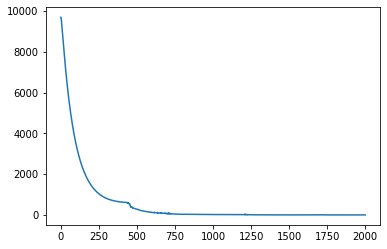

In [10]:
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.show()